In [1]:
root="C:/github/2023/RatDeconvolution"
path_package="D:/Gdrive/publication/ratdeconv"

## Deconvolution

In [2]:
import sys
import warnings

import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

sys.path.append(path_package)
from deconv.deconv.deconv import Deconvolution

plt.rcParams["font.size"] = 22
plt.rcParams['font.family'] = 'sans-serif'
warnings.simplefilter('ignore')

In [3]:
def annotation_sample(df, df_b):
    temp = df_b.loc[df.columns.tolist()]
    name = temp["COMPOUND_NAME"].tolist()
    dose = temp["DOSE_LEVEL"].tolist()
    time = temp["SACRIFICE_PERIOD"].tolist()
    ind = [f"{i}_{j}_{k}" for i, j, k in zip(name, dose, time)]
    return ind

def estimate(df_mix, df_ref, number=150, trimming=True, trans="log2",norm=["quantile"]):
    dat = Deconvolution()
    dat.set_data(df_mix, df_ref)
    dat.preprocessing_mix(
                        trimming=trimming,batch=False,combat=False,
                        trans_method=trans,
                        norm_method_list=norm)
    dat.deg(method="ttest",
            sep="_",number=number,limit_CV=1.,limit_FC=1.,log2=True,q_limit=0.05,
            intersection=trimming,
            plot=True)
    dat.preprocessing_ref(
            trimming=False,batch=False,combat=False,
            trans_method=trans,
            norm_method_list=["raw"])
    df_ref_processed = dat.get_data()[1]
    dat.set_data(df_mix, df_ref_processed)
    dat.preprocessing_mix(
                        trimming=False,batch=False,combat=False,
                        trans_method=trans,
                        norm_method_list=norm)    
    dat.fit(method="elasticnet")
    df_res = dat.get_res()
    return df_res


In [4]:
# load transcriptome
df_target = pd.read_csv(f"{root}/data/tggate_transcriptome.csv",index_col=0)
df_sample = pd.read_csv(f"{root}/data/tggate_sample_information.csv",index_col=0)
df_target.columns=[str(i) for i in df_target.columns]
df_sample.index=[str(i) for i in df_sample.index]
df_target.columns = annotation_sample(df_target, df_sample)
print(df_target.shape)

# load ref raw file
df_ref = pd.read_csv(f"{root}/data/rnaseq_reference.csv", index_col=0)
df_ref = df_ref.loc[:,[
    'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 
    'CD4T_1', 'CD4T_2', 'CD4T_3', 'CD4T_4', 'CD4T_5', 'CD4T_6',
    'CD8T_1', 'CD8T_2', 'CD8T_3', 'CD8T_4', 'CD8T_5', 'CD8T_6', 
    'NK_1', 'NK_2', 'NK_3', 'NK_4', 'NK_5', 'NK_6',
    'Mon_1', 'Mon_2', 'Mon_3', 'Mon_4', 'Mon_5', 
    'Mon_6', 'Neu_1', 'Neu_2', 'Neu_3', 'Neu_4', 'Neu_5', 'Neu_6', 
]]

(13323, 645)


method : ttest
extracted genes number = 2063
extracted genes number = 4243
extracted genes number = 3729
not enough genes picked up
extracted genes number = 2362
extracted genes number = 6258
extracted genes number = 4885
signature genes : 1050


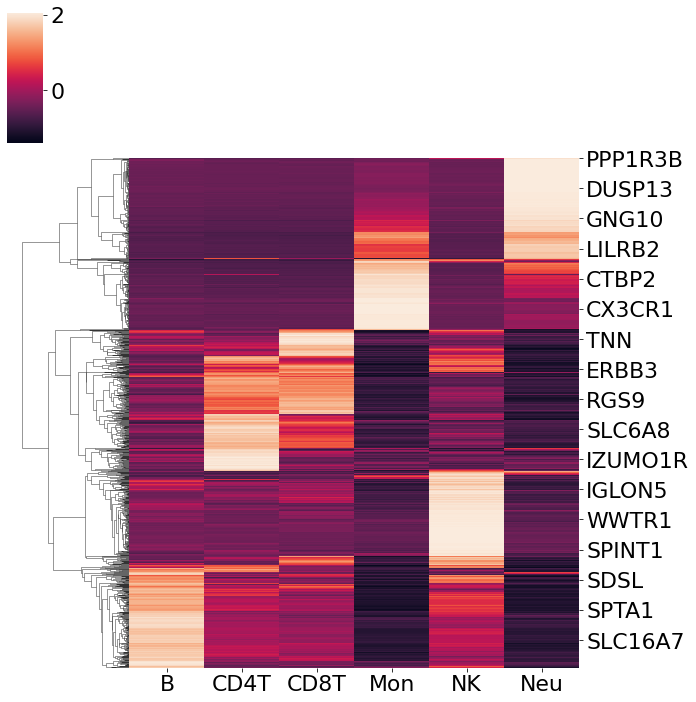

method:  elasticnet


In [5]:
df_res = estimate(df_target, df_ref, number=200, trimming=True, trans="log2",norm=["quantile"])
df_res.to_csv(f"{root}/result/tggate_result.csv")

## Evaluation

In [6]:
def calc_z(res, drugs=list(), ctrl:str="Control"):
    df_z = pd.DataFrame(columns=res.columns.tolist())
    for drug in drugs:
        res_temp = res.loc[res.index.str.contains(drug),:]
        res_ctrl = res_temp.loc[res_temp.index.str.contains(ctrl),:]
        res_drug = res_temp.loc[~res_temp.index.str.contains(ctrl),:]
        
        mean = np.nanmean(res_ctrl.values,axis=0)
        std = np.nanstd(res_ctrl.values,axis=0)
        res_z = pd.DataFrame((res_drug.values - mean)/std)
        res_z.index = res_drug.index
        res_z.columns = res_drug.columns
        res_z = res_z.replace(np.inf,0)
        res_z = res_z.replace(-np.inf,0)
        res_z = res_z.fillna(0)
        if len(res.index)!=0:
            df_z = pd.concat([df_z, res_z],axis=0)
    return df_z

def calc_z_all(res, ctrl_name="ctrl"):
    res_ctrl = res.loc[res.index.str.contains(ctrl_name),:]
    res_drug = res.loc[~res.index.str.contains(ctrl_name),:]
    mean = np.mean(res_ctrl.values,axis=0)
    std = np.std(res_ctrl.values,axis=0)
    res_z = pd.DataFrame((res_drug.values - mean)/std)
    res_z.index = res_drug.index
    res_z.columns = res_drug.columns
    res_z = res_z.replace(np.inf,0)
    res_z = res_z.replace(-np.inf,0)
    res_z = res_z.fillna(0)
    return res_z

def calc_stat(arr, median=True):
    v_median = np.nanmedian(arr)
    v_mean = np.nanmean(arr)
    v_var = st.tvar(arr)
    a, b = st.norm.interval(alpha=0.95, loc=v_mean, scale=np.sqrt(v_var/len(arr)))
    if median:
        return v_median, b-v_mean
    else:
        return v_mean, b-v_mean
        
def load_data():
    # load
    df_res = pd.read_csv(f"{root}/result/tggate_result.csv", index_col=0)
    target_compounds = list(set([i.split("_")[0] for i in df_res.index.tolist()]))
    # processing
    ## Z score to control
    df_res = df_res.loc[~df_res.index.str.contains("day"),:]
    df_res = df_res.loc[(df_res.index.str.contains("Control"))|(df_res.index.str.contains("High")),:]
    df_res_z = calc_z(df_res, drugs=target_compounds, ctrl="Control")
    df_res_z.index = [i.rsplit(" ", 1)[0]+" h" if i.rsplit(" ", 1)[-1]=="hr" else i for i in df_res_z.index]
    return df_res_z, target_compounds    

def load_data2():
    # load
    df_res = pd.read_csv(f"{root}/result/tggate_result.csv", index_col=0)
    df_count = pd.read_csv(f"{root}/data/tggate_validation_count.csv", index_col=0)
    target_compounds = list(set([i.replace("_Ctrl","") for i in df_count.index.tolist()]))
    # processing
    ## Z score to control
    df_res = df_res.loc[~df_res.index.str.contains("day"),:]
    df_res = df_res.loc[(df_res.index.str.contains("Control"))|(df_res.index.str.contains("High")),:]
    df_res_z = calc_z(df_res, drugs=list(set([i.split("_")[0] for i in target_compounds])), ctrl="Control")
    df_res_z.index = [i.replace("_High", "") for i in df_res_z.index]
    df_count_z=list()
    for comp in target_compounds:
        df_temp = df_count.loc[df_count.index.str.contains(comp),:]
        df_temp = calc_z_all(df_temp, ctrl_name="Ctrl")
        df_count_z.append(df_temp)
    df_count_z = pd.concat(df_count_z, axis=0)
    return df_res_z, df_count_z



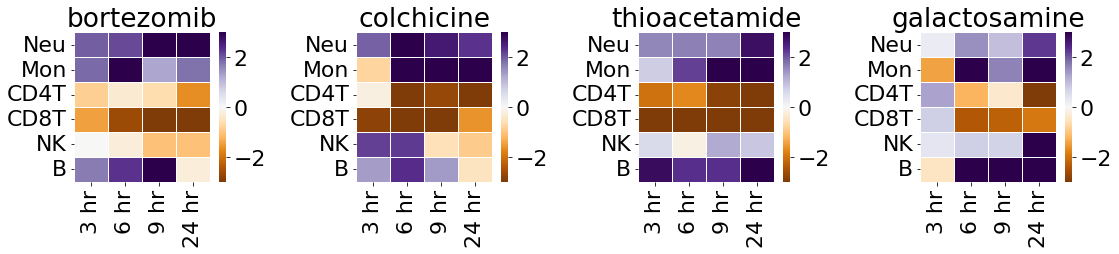

In [7]:
def plot_fig3a():
    def plot_heatmap(df, drugs, scales=[-3, 3], cmap="PuOr"):
        fig = plt.figure(figsize=(16,4))
        for v, drug in enumerate(drugs):
            # processing
            df_temp = df.loc[df.index.str.contains(drug),:]
            df_temp = df_temp.groupby(axis=0, level=0).mean()
            sorter = [(int(i.split("_")[-1].split("h")[0]), i) for i in df_temp.index.tolist()]
            sorter = sorted(sorter)
            df_temp = df_temp.loc[[i[1] for i in sorter],:]
            # plot
            ax = fig.add_subplot(1, 4, v+1)
            #sns.heatmap(df_temp.T, cmap='RdYlBu', ax=ax, linewidths=.5, vmax=scales[1], vmin=scales[0], square=True)
            sns.heatmap(df_temp.T, cmap=cmap, ax=ax, linewidths=1., vmax=scales[1], vmin=scales[0])
            ax.set_title(drug)
            ax.set_yticklabels(df_temp.columns, rotation=0)
            ax.set_xticklabels(["3 hr", "6 hr", "9 hr", "24 hr"], rotation=90)
        plt.tight_layout()
        plt.show()
    df_all, target_compounds = load_data()
    target_compounds = [
        'bortezomib',
        'colchicine',
        'thioacetamide',
        'galactosamine'
    ]
    lst = ["Neu", "Mon", "CD4T", "CD8T", "NK", "B"]
    plot_heatmap(df_all.loc[:,lst], target_compounds, scales=[-3, 3])

plot_fig3a()

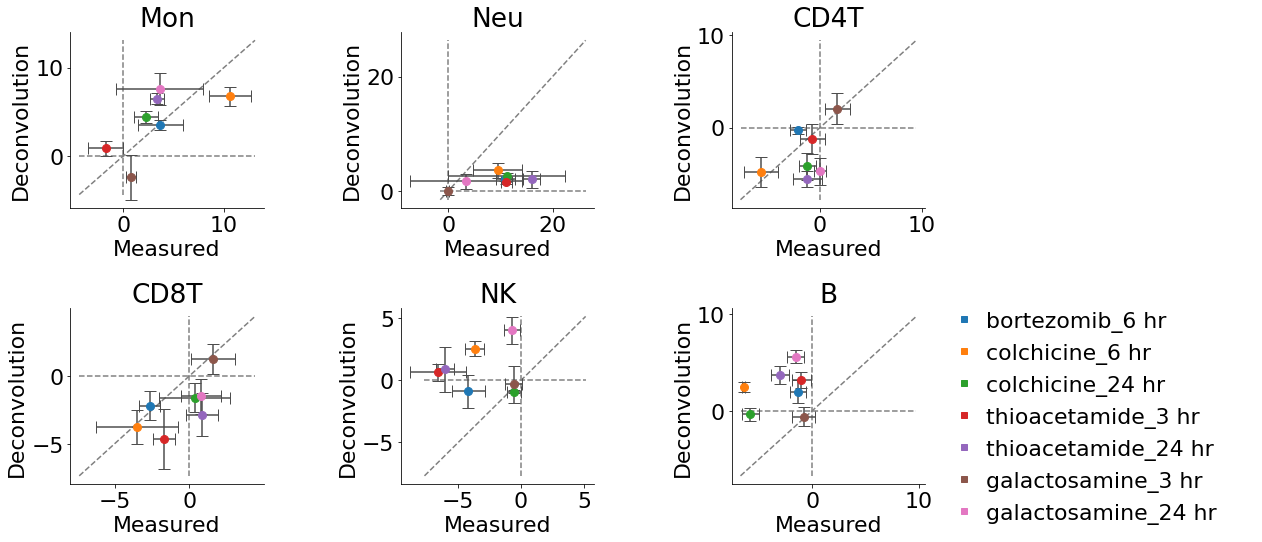

In [8]:
def plot_fig3b():
    def plot_immune(df1, df2, drugs=[], figsize=()):
        immunes=["Mon", "Neu", "CD4T", "CD8T", "NK", "B"]
        fig = plt.figure(figsize=figsize)
        places=[1,2,3,5,6,7]
        for v, immune in enumerate(immunes):
            df_1 = df1.loc[:, immune]
            df_2 = df2.loc[:, immune]
            lst_stats_1 = [calc_stat(df_1[drug].values) for drug in drugs]
            lst_stats_2 = [calc_stat(df_2[drug].values) for drug in drugs]
            colors = sns.color_palette(n_colors=len(drugs))
            ax = fig.add_subplot(2, 4, places[v])        
            # control lines
            x_min = df_1.min()
            x_max = df_1.max()
            y_min = df_2.min()
            y_max = df_2.max()
            min_all = min(y_min, x_min)
            max_all = max(y_max, x_max)
            ax.plot([min_all, max_all], [min_all, max_all], color='grey', linestyle='dashed')
            ax.hlines(y=0,xmin=min_all,xmax=max_all, color='grey', linestyles='dashed')
            ax.vlines(x=0,ymin=min_all,ymax=max_all, color='grey', linestyles='dashed')
            # Plot
            for i, drug in enumerate(drugs):
                ax.errorbar(lst_stats_1[i][0], lst_stats_2[i][0], xerr=lst_stats_1[i][1], yerr=lst_stats_2[i][1], capsize=6, color="0.3")
            for i, drug in enumerate(drugs):        
                ax.plot(lst_stats_1[i][0], lst_stats_2[i][0], markersize=8, linestyle='None', marker="o", color=colors[i], label=drug)
            ax.set_xlabel('Measured')
            ax.set_ylabel('Deconvolution')
            ax.set_title(immune)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().yaxis.set_ticks_position('left')
            plt.gca().xaxis.set_ticks_position('bottom')   
        # For Legend
        ax = fig.add_subplot(2,4,8)
        for i, drug in enumerate(drugs):
            ax.plot([], [], marker="s", color=colors[i], label=drug, linestyle="none")
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        legend = ax.legend(bbox_to_anchor=(0.9, 1.1), loc='upper right',frameon=False, handletextpad=0, ncol=1, columnspacing=1)
        plt.tight_layout()
        plt.show()
    drugs = [
        'bortezomib_6 hr', 
        'colchicine_6 hr', 
        'colchicine_24 hr',
        'thioacetamide_3 hr', 
        'thioacetamide_24 hr', 
        'galactosamine_3 hr',
        'galactosamine_24 hr',
    ]
    df_res_z, df_count_z = load_data2()
    plot_immune(df_count_z, df_res_z, drugs=drugs, figsize=(18,8))
plot_fig3b()